<a href="https://colab.research.google.com/github/AnIsAsPe/Regresion-Robusta-para-estimar-tiempo-de-respuesta-de-un-servicio-de-emergencia/blob/main/Comparaci%C3%B3n_regresiones_lineal%2C_polinomial_y_robusta_response_time_Paris_Fire_Brigade.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Ejercicio que compara la regresión lineal, polinomial y robusta (Hubber) utilizando solamente las variables propuestas en el [starting script ](https://paris-fire-brigade.github.io/data-challenge/challenge.html) del Challenge

## Cargar bibiliotecas

In [6]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split 

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import HuberRegressor
from sklearn import metrics

import matplotlib.pyplot as plt 
import seaborn as sns  

# Cargar datos

In [8]:
# Conjunto de caracteristicas (X)
input = pd.read_csv('drive/My Drive/Datos/ParisFireBrigade/x_train.csv', 
                sep=',', index_col=[0], parse_dates=['selection time'] )
print(input.shape)
input.head(2)

(219337, 25)


,intervention,alert reason category,alert reason,intervention on public roads,floor,location of the event,longitude intervention,latitude intervention,emergency vehicle,emergency vehicle type,rescue center,selection time,date key sélection,time key sélection,status preceding selection,delta status preceding selection-selection,departed from its rescue center,longitude before departure,latitude before departure,delta position gps previous departure-departure,GPS tracks departure-presentation,GPS tracks datetime departure-presentation,OSRM response,OSRM estimated distance,OSRM estimated duration
emergency vehicle selection,,,,,,,,,,,,,,,,,,,,,,,,,
5105452,13264186,3,2162,0,0,148.0,2.284796,48.879669,4511,VSAV BSPP,2447,2018-07-08 19:02:43.990,20180708,190243,Rentré,2027,1,2.288053,48.884698,NaN,"2.289000,48.885113;2.288861,48.884998;2.288000...",2018-07-08 19:04:43;2018-07-08 19:05:55;2018-0...,"{""code"":""Ok"",""routes"":[{""geometry"":""}yjiH}x}L_...",952.5,105.8
4720915,12663715,3,2124,0,1,136.0,2.247464,48.818191,4327,PSE,2464,2018-01-04 09:02:59.470,20180104,90259,Rentré,28233,1,2.268519,48.823958,NaN,NaN,NaN,"{""code"":""Ok"",""routes"":[{""geometry"":""u|~hHy`zL_...",2238.5,243.2


In [9]:
# Variables respuesta
output = pd.read_csv('drive/My Drive/Datos/ParisFireBrigade/y_train.csv', 
                     index_col=[0], sep=',')
print(output.shape)
output.head(2)

(219337, 3)


,delta selection-departure,delta departure-presentation,delta selection-presentation
emergency vehicle selection,,,
5105452,86,324,410
4720915,164,297,461


In [10]:
X = input[['OSRM estimated distance','intervention on public roads','floor']]
Z = output['delta departure-presentation']

# Unir caracteristicas con étiquetas

In [11]:
df=pd.concat([X,Z], axis=1)
print(df.shape)
df.head(2)

(219337, 4)


,OSRM estimated distance,intervention on public roads,floor,delta departure-presentation
emergency vehicle selection,,,,
5105452,952.5,0,0,324
4720915,2238.5,0,1,297


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 219337 entries, 5105452 to 4868867
Data columns (total 4 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   OSRM estimated distance       219337 non-null  float64
 1   intervention on public roads  219337 non-null  int64  
 2   floor                         219337 non-null  int64  
 3   delta departure-presentation  219337 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 8.4 MB


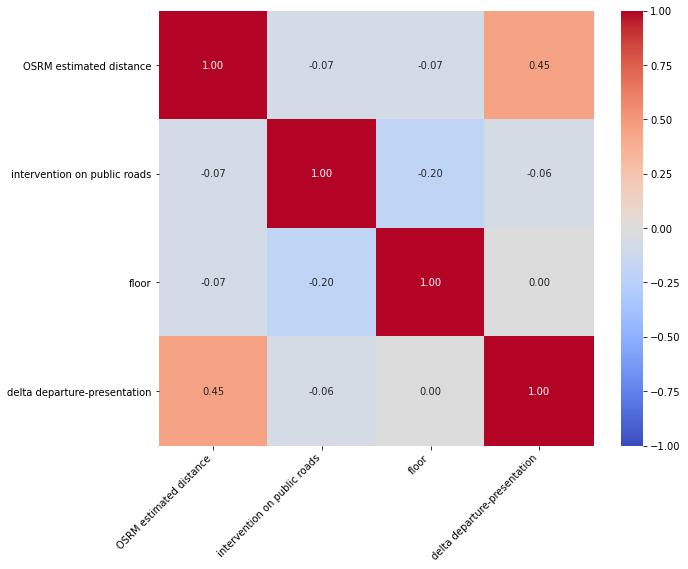

In [13]:
corr_matrix = correlacion(df, matrix = True, tamaño=(10,8))

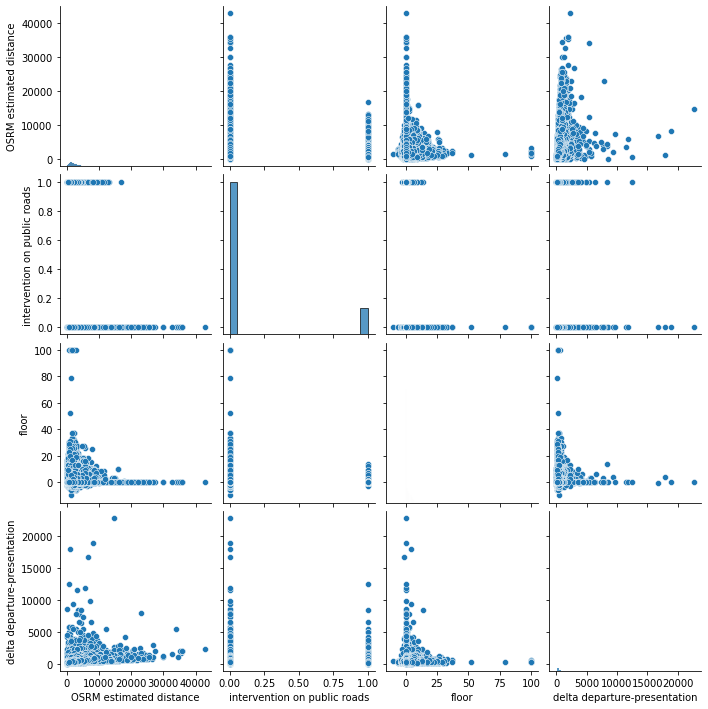

In [14]:
sns.pairplot(df)

# Exploración de Outliers

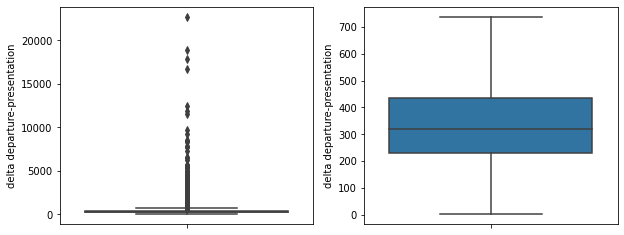

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
for cond, subplot in zip((True, False), ax.flatten()):
  sns.boxplot(y=df['delta departure-presentation'], showfliers=cond, ax= subplot)

# Comparación Regresión lineal, Regresión robusta

In [16]:
X_train, X_test, Z_train, Z_test = train_test_split(X, Z, 
                                                    test_size=0.3, 
                                                    shuffle=True,
                                                    random_state=261)

In [17]:
# ¿Cómo son los conjuntos de entrenamiento y prueba?
print("Conjunto de entrenamiento")
print("X: ", X_train.shape)
print("y: ", Z_train.shape)

print("Conjunto de prueba")
print("X: ", X_test.shape)
print("y: ", Z_test.shape)

Conjunto de entrenamiento
X:  (153535, 3)
y:  (153535,)
Conjunto de prueba
X:  (65802, 3)
y:  (65802,)


## Regresión Lineal

In [18]:
lr = LinearRegression().fit(X_train, Z_train)

Z_pred = lr.predict(X_test)

error_medio_absoluto = np.mean(np.absolute(Z_test - Z_pred ))
error_medio_absoluto

108.95440215014592

In [19]:
metrics.mean_absolute_error(Z_test, Z_pred)

108.95440215014527

In [20]:
#calculamos los errores
errores = (np.array(Z_test) - Z_pred)
len(errores)

65802

In [21]:
#una de las hipotesis de la regresión es que los errores son
#independientes  entre sí, teniendo una distribución normal

media = np.mean(Z_test - Z_pred)           
des_est = np.sqrt(np.var(Z_test - Z_pred))

media,des_est

(1.5636611530992213, 204.28732738705733)

### Comparación de los errores empirícos con una la distribución normal

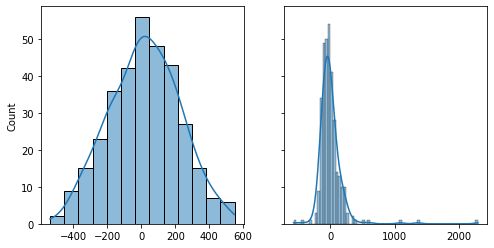

In [22]:
# Comparación de la distribución teórica(normal) y empirica de los errores

# Se elige una submuestra (%0.5) con el propósito de obtener una mejor visualización
errores_empiricos = np.random.choice(errores, 329)

# Se obtienen 329 valores a partir de la distribución normal (teorica) usando la media
# y la desviación de los errores
errores_teoricos = np.random.normal(media, des_est, 329)

# Comparamos las gráficas de ambas distribuciones

fig, ax = plt.subplots(1, 2, figsize=(8, 4), sharey='all')
for dat, subplot in zip((errores_teoricos, errores_empiricos), ax.flatten()):
  sns.histplot(x=dat, ax=subplot, kde=True, )
  
plt.show()

## Regresión Robusta

In [23]:
hr = HuberRegressor( epsilon=1.35,   max_iter=1000,  alpha=0,  warm_start=False, 
                    fit_intercept=True, tol=1e-05)
hr = hr.fit(X_train, Z_train)
Z_pred = hr.predict(X_test)

print(metrics.mean_absolute_error(Z_test, Z_pred))
print('MAE:', metrics.mean_absolute_error(Z_test, Z_pred))

105.59182049604047
MAE: 105.59182049604047


In [24]:
hr.coef_

array([  0.07000484, -13.14099164,   2.59506495])

In [25]:
coeficientes_hr = pd.DataFrame({'coef':hr.coef_, 'variable':list(X.columns)})
coeficientes_hr.sort_values('coef').reset_index(drop=True)

,coef,variable
0,-13.140992,intervention on public roads
1,0.070005,OSRM estimated distance
2,2.595065,floor


# Regresiones polinomial

In [26]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

In [27]:
polynomial_features = PolynomialFeatures(degree=3)
X_train_poly = polynomial_features.fit_transform(X_train)
X_test_poly = polynomial_features.fit_transform(X_test)


reg_poly = LinearRegression().fit(X_train_poly, Z_train)

Z_pred = reg_poly.predict(X_test_poly)
                  
error_medio_absoluto = np.mean(np.absolute(Z_test - Z_pred ))
error_medio_absoluto

107.62779786852137

In [28]:
polynomial_features = PolynomialFeatures(degree=2)
X_train_poly = polynomial_features.fit_transform(X_train)
X_test_poly = polynomial_features.fit_transform(X_test)


reg_poly = LinearRegression().fit(X_train_poly, Z_train)

Z_pred = reg_poly.predict(X_test_poly)
                  
error_medio_absoluto = np.mean(np.absolute(Z_test - Z_pred ))
error_medio_absoluto

107.97981717963303